<a href="https://colab.research.google.com/github/thatguycharles/exercise3/blob/main/Copy_of_CompModNervSys_exercise3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOL 74.03 (SP23): Computational Modeling of the Nervous System 
## Exercise 3: Calculating membrane voltage and ionic currents in cells

### Exercise goals

1) Calculate resistances and capacitances within cellular geometries. 

2) Get comfortable writing code implementing mathematical equations and handling units

3) Use the Nernst equation to calculate ionic reversal potentials

4) Use the Goldman equation to calcualte resting membrane potentials

5) Analyze a simple RC circuit, a building block on the way to our first neuron model

Work through the code below, running each cell, adding code where required, and making sure you understand the output. When you see questions with ***Q:*** preceding them, write your responses in text cells. 

In [1]:
!git clone https://github.com/CompModNervSystem/CompModNervSys-NernstVm.git # downloads repository into our Google colab session's file system

Cloning into 'CompModNervSys-NernstVm'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 3), reused 16 (delta 3), pack-reused 0
Unpacking objects: 100% (16/16), 148.78 KiB | 5.51 MiB/s, done.


# Membrane resistance and capacitance

Suppose we have a spherical cell with diameter $d$ and a membrane with thickness $t$. Recall that resistance $R$ is given by $R = \rho L/A$, where $\rho$ is the resistivity of the medium, $L$ is the length over which current travels, and $A$ is the cross-sectional area. Write a function that computes the membrane resistance given a membrane resistivity $\rho_{m}$, which has units $\Omega \cdot cm$. Use this function to compute the membrane resistance of a cell in units of $M\Omega$ with a $10 \; \mu m$ diameter, membrane thickness of $3 \; nm$ (this refers to the insulating part of the lipid bilayer), and resistivity of $5 \; G \Omega cm$ ($1\cdot10^{9} \Omega cm$) and print the output. 

For a refresher on converting between metric units, see the chart below:

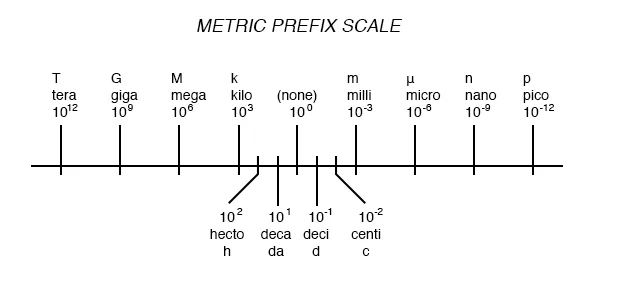

In [2]:
from IPython.display import Image
Image('CompModNervSys-NernstVm/resources/metric-prefix-scale.jpeg',width=500)

In [3]:
import numpy as np
import math

def calcRsphericalCell(rho_m, d,t):
    R = rho_m * t / (4 * math.pi * (d/2)**2)
    return R * 10**(-6)

rho_m = 5 * 10**9 # resistivity - Ohm*cm 
d = 10 * 10**(-4) # diameter - cm
t = 3 * 10**(-7) # thickness - cm 

R = calcRsphericalCell(rho_m,d,t)
print('Resistance = {:.1f} MOhms'.format(R))

Resistance = 477.5 MOhms


***Q1***: How would you convert this to the membrane's conductance?

**You would simply calculate G = 1/R**

Now, write a similar function to calculate the membrane's capacitance. Recall the equation for capacitance of parallel plates is $C = \epsilon A/L$, where $\epsilon$ is the dielectric constant of the medium's between the plates, $A$ is the surface area, and $L$ is the distance between the plates. Use this function to compute the membrane capacitance of the same cell in units of $pF$ with $\epsilon = 0.3 pF/cm$ and print the output.

In [4]:
def calcCsphericalCell(eps_m, d,t):
    C = eps_m * (4 * math.pi * (d/2)**2) / t
    return C * 10**12

eps_m = 0.3e-12 # dielectric constant - F/cm
d = 10e-4 # diameter - cm
t = 3e-7 # thickness - cm 

C = calcCsphericalCell(eps_m,d,t)
print('Capacitance = {:.3f} pF'.format(C))



Capacitance = 3.142 pF


Since the membrane thickness is essentially constant across all excitable cells, it's often easier to refer to the *specific membrane resistance*, $R_{m}$, which is the resistance per unit area, and the *specific membrane capacitance*, $C_{m}$, which is the capacitance per unit area. $R_{m}$ is just the numerator of our resistance equation, so $\rho_{m}t$, and $C_{m}$ is obtained by combining the $\epsilon/t$ terms from the capacitance equation. 

***Q2***: What values of $R_{m}$, in units of $\Omega cm^{2}$, and $C_{m}$, in units of $\mu F/cm^{2}$, do we get using the values given above? How does the cell's total membrane resistance $R$ and capacitance $C$ scale with the diameter and surface area of the cell? 
These are the quantities you're more likely to see reported in experimental and modeling literature and that we'll be using in our models. 

In [5]:
rho_m = 5 * 10**9 # resistivity - Ohm*cm 
eps_m = 0.3e-6 # dielectric constant - uF/cm
d = 10e-4 # diameter - cm
t = 3e-7 # thickness - cm 
Rm = rho_m*t
Cm = eps_m / t
print('Rm = {:.3f} Ohmcm2'.format(Rm))
print('Cm = {:.3f} uF/cm2'.format(Cm))


Rm = 1500.000 Ohmcm2
Cm = 1.000 uF/cm2


**R decreases exponentially as diameter increases, and decreases proportionally to an increase in surface area. This is evident by the (4*pi*(d/2)^2) expression in the denominator. Similarly, C increases exponentially with diameter and decreases proportionally to an increase in surface area, as the same (4*pi*(d/2)^2) appears in the numerator.**

Now, write new functions calculating the membrane resistance an capacitance, based on your functions above that instead take as input $R_{m}$ and $C_{m}$. Check that you get the same output as above. Be careful about units!

In [8]:
def calcCsphericalCell(Cm, d): # Cm in units of uF/cm2
    C = Cm * (4 * math.pi * (d/2)**2)
    return C * 10**6

def calcRsphericalCell(Rm, d): # Rm in units of Ohmcm2
    R = Rm / (4 * math.pi * (d/2)**2)
    return R * 10**(-6)

C = calcCsphericalCell(Cm, d)
R = calcRsphericalCell(Rm, d)

print('Resistance = {:.1f} MOhms'.format(R))

print('Capacitance = {:.3f} pF'.format(C))

Resistance = 477.5 MOhms
Capacitance = 3.142 pF


# Calculating the Nernst potential

Now let's calculate the Nernst equilibrium potential for some typical ion concentrations in mammalian neurons. Recall the Nernst equation is:

$V_{m}^{eq} = RT/ZF \ln([C]_e/[C]_i)$

Where $R$ is the gas constant, $8.314 J/K \cdot mole$, $T$ is temperature in $K$ (Kelvin), $Z$ is the ion's valence (don't forget the sign!), and $F$ is Faraday's constant, $96,485.3 C/mole$. $[C]_e$ and $[C]_i$ are the extracellular and intracellular concentrations. 

***Q3***: Do the units of concentration matter in this equation?

**No. The units cancel to produce a unitless ratio within the parentheses of the ln expression.**

| Ion            | Intracellular [mM] | Extracellular [mM] |
| -------------- | ------------------ | ------------------ |
| Potassium (K+) | 140 | 5 |
| Sodium (Na+) | 15 | 145 |
| Chloride (Cl-) | 5 | 110 |


Write a single function that outputs the Nernst potential for a given ion. Then, using your function and the concentrations above, print the Nernst potentials (in $mV$) for potassium, sodium, and chloride for a neuron at body temperature ($37^{\circ} C$). Just use 1 decimal place for outputting these values. 

In [12]:
def calcNernstIon(IntraC, ExtraC, temp, valence):
    R = 8.314 # J/Kmol
    T = temp # K
    Z = valence # valence
    F = 96485.3 # C/mol 
    CC = ExtraC / IntraC

    V = R * T / (Z * F) * math.log(CC)

    return V * 1e3

Ek = calcNernstIon(140, 5, 310, 1)
Ena = calcNernstIon(15, 145, 310, 1)
Ecl = calcNernstIon(5, 110, 310, -1)
print('Ek = {:.1f} mV, Ena = {:.1f} mV, Ecl = {:.1f} mV'.format(Ek,Ena,Ecl))

Ek = -89.0 mV, Ena = 60.6 mV, Ecl = -82.6 mV


This gives us the reversal potential for individual ions, but we know from the Goldman equation that the actual rest potential is a function of the ion concentrations *and* their permeabilities in the membrane. The Goldman equation is given by:

$V_{m}^{eq} = \frac{RT}{ZF}\ln \left( \frac{P_{K}[K]e + P_{Na}[Na]e + P_{Cl}[Cl]i}{P_{K}[K]i + P_{Na}[Na]i + P_{Cl}[Cl]e} \right)$

Write a function that uses the Goldman equation to compute the resting potential given a set of K, Na, and Cl- permeabilities and concentrations. Use it to calculate the resting potential given relative resting permeabilities $P_{K}:P_{Na}:P_{Cl}$ of $1:0.05:0.45$ at body temperature and print the output in $mV$.

In [16]:
def calcVmGoldman(Pk, Pna, Pcl, Ke, Ki, Nae, Nai, Cle, Cli, temp):
    R = 8.314 # J/Kmol
    T = temp # K
    Z = 1 # K, Na have valence 1, Cl -1 but is accounted for by inverting in the log expression
    F = 96485.3 # C/mol 

    V = R * T / (Z * F) * math.log((Pk*Ke+Pna*Nae+Pcl*Cli)/(Pk*Ki+Pna*Nai+Pcl*Cle))

    return V * 1e3

Pk = 1
Pna = .05
Pcl = .45
Ke = 5
Ki = 140
Nae = 145
Nai = 15
Cle = 110
Cli = 5
bodytemp = 310

Vm = calcVmGoldman(Pk, Pna, Pcl, Ke, Ki, Nae, Nai, Cle, Cli, bodytemp)

print('Resting Vm = {:.1f} mV'.format(Vm))

Resting Vm = -68.8 mV


Now, suppose we were doing an experiment where we had some neurons in a dish and can control the concentration of ions in the extracellular solution. When mimicking the normal extracellular environment of neurons, this solution is sometimes called artificial cerebrospinal fluid (aCSF). It also includes other important things like buffers and energy sources (glucose) so our neurons are happy outside of the brain where they usually belong, but for our purposes, the ions are what matters. 

We want to see how resting membrane potential varies with extracellular potassium concentration, which we control in the aCSF. We can measure the intracellular voltage of the cell with a special electrode made out of a glass micropipette pulled to a fine tip less than 1 $\mu m$ in diameter containing an electrolyte solution mimicking the cytosol and a wire that connects to a fancy voltmeter that amplifies small voltage or current signals. We'll talk more about this technique, called patch clamp electrophysiology, in class. 

Assuming your function worked, you can tell that the resting membrane potential is closest to the Nernst potential for potassium ($E_{k}$). If we did an experiment varying the extracellular potassium concentration and measuring resting membrane potential, what would we see? Use `matplotlib` (or your preferred plotting package) to plot the resting membrane potential vs. extracellular potassium concentration. Assume all the other intracellular and extracellular concentrations are the same as before and we heated up our neurons to body temperature. Use a log-scale on the x-axis. (Hint: your output should look like Figure 2.7 from Ch.2 of Purves, Neuroscience, the assigned reading).

(-80.0, 10.0)

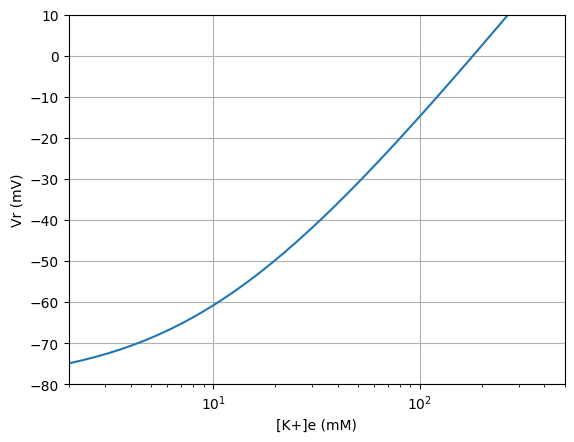

In [35]:
import matplotlib.pyplot as plt

Ce_k_vec = np.logspace(0,3) # fill in arguments # vector of concentrations in mM
Vm_vec = np.zeros(Ce_k_vec.shape)
for i in range(len(Ce_k_vec)):
  Vm_vec[i] = calcVmGoldman(Pk, Pna, Pcl, Ce_k_vec[i], Ki, Nae, Nai, Cle, Cli, bodytemp)
fig = plt.figure()
ax = fig.add_subplot(111)
# Plot statement goes here
ax.plot(Ce_k_vec,Vm_vec)
#
ax.grid(visible=True)
ax.set_xscale('log')
ax.set_xlabel('[K+]e (mM)')
ax.set_ylabel('Vr (mV)')
ax.set_xlim([2, 500])
ax.set_ylim([-80,10])

Let's say we wanted to do an experiment where we raised the resting membrane potential by $10 mV$ from the value you calculated earlier. What concentration of K+ should we use in the extracellular solution? 

You could do some math to work this out, or if you're lazy (like me), write some code to work it out for you. One way would be to just plug in a vector of finely sampled $[K+]_{e}$ (guesses) to the Goldman equation function you wrote and extract the resting membrane potential closest to our desired potential. Write a function below that does this using either this method or a method of your choosing. If you get stuck here, you can just use the "guess and check" method with your function and move on. 


In [48]:
def findVrplusten():
  Pk = 1
  Pna = .05
  Pcl = .45
  Ke = 5
  Ki = 140
  Nae = 145
  Nai = 15
  Cle = 110
  Cli = 5
  bodytemp = 310 
  Vm = calcVmGoldman(Pk, Pna, Pcl, Ke, Ki, Nae, Nai, Cle, Cli, bodytemp)

  Ke_vec = np.linspace(10, 15, 100)
  closestK = 8
  temp = Vm
  for Ke in Ke_vec:
    Vtemp = calcVmGoldman(Pk, Pna, Pcl, Ke, Ki, Nae, Nai, Cle, Cli, bodytemp)
    if(abs(Vtemp-(Vm+10))<abs(Vm+10-temp)):
      temp = Vtemp
      closestK = Ke

  return closestK

print('Found Ke: {:.2f}'.format(findVrplusten()))
print('Recalculating Vr: {:.2f}'.format(calcVmGoldman(Pk, Pna, Pcl, findVrplusten(), Ki, Nae, Nai, Cle, Cli, 310)))

Found Ke: 11.57
Recalculating Vr: -58.79


# First look at the RC circuit model

Let's start playing with the most basic circuit model of a cell membrane, an RC circuit, shown below. In this case, we're modeling the membrane conductance as *passive*, i.e., ignoring the presence of nonlinear voltage gated ion channels. This turns out to be a decent model of neuronal membranes at voltages near equilibrium, since the nonlinear currents are still small. The circuit is composed of the membrane capacitance $C_{m}$ in parallel with a resistor $R$ representing an ionic conductance ($g=1/R$) with a reversal potential $E_{rev}$. This is sometimes referred to as the *leak* conductance and is simply the total conductance of the membrane's ion channels at rest lumped together and treated as passive (non-voltage dependent). Since we only have a single leak conductance, this is equivalent to the membrane resistance, $R_{m}$, which we'll use in the model equations below. 

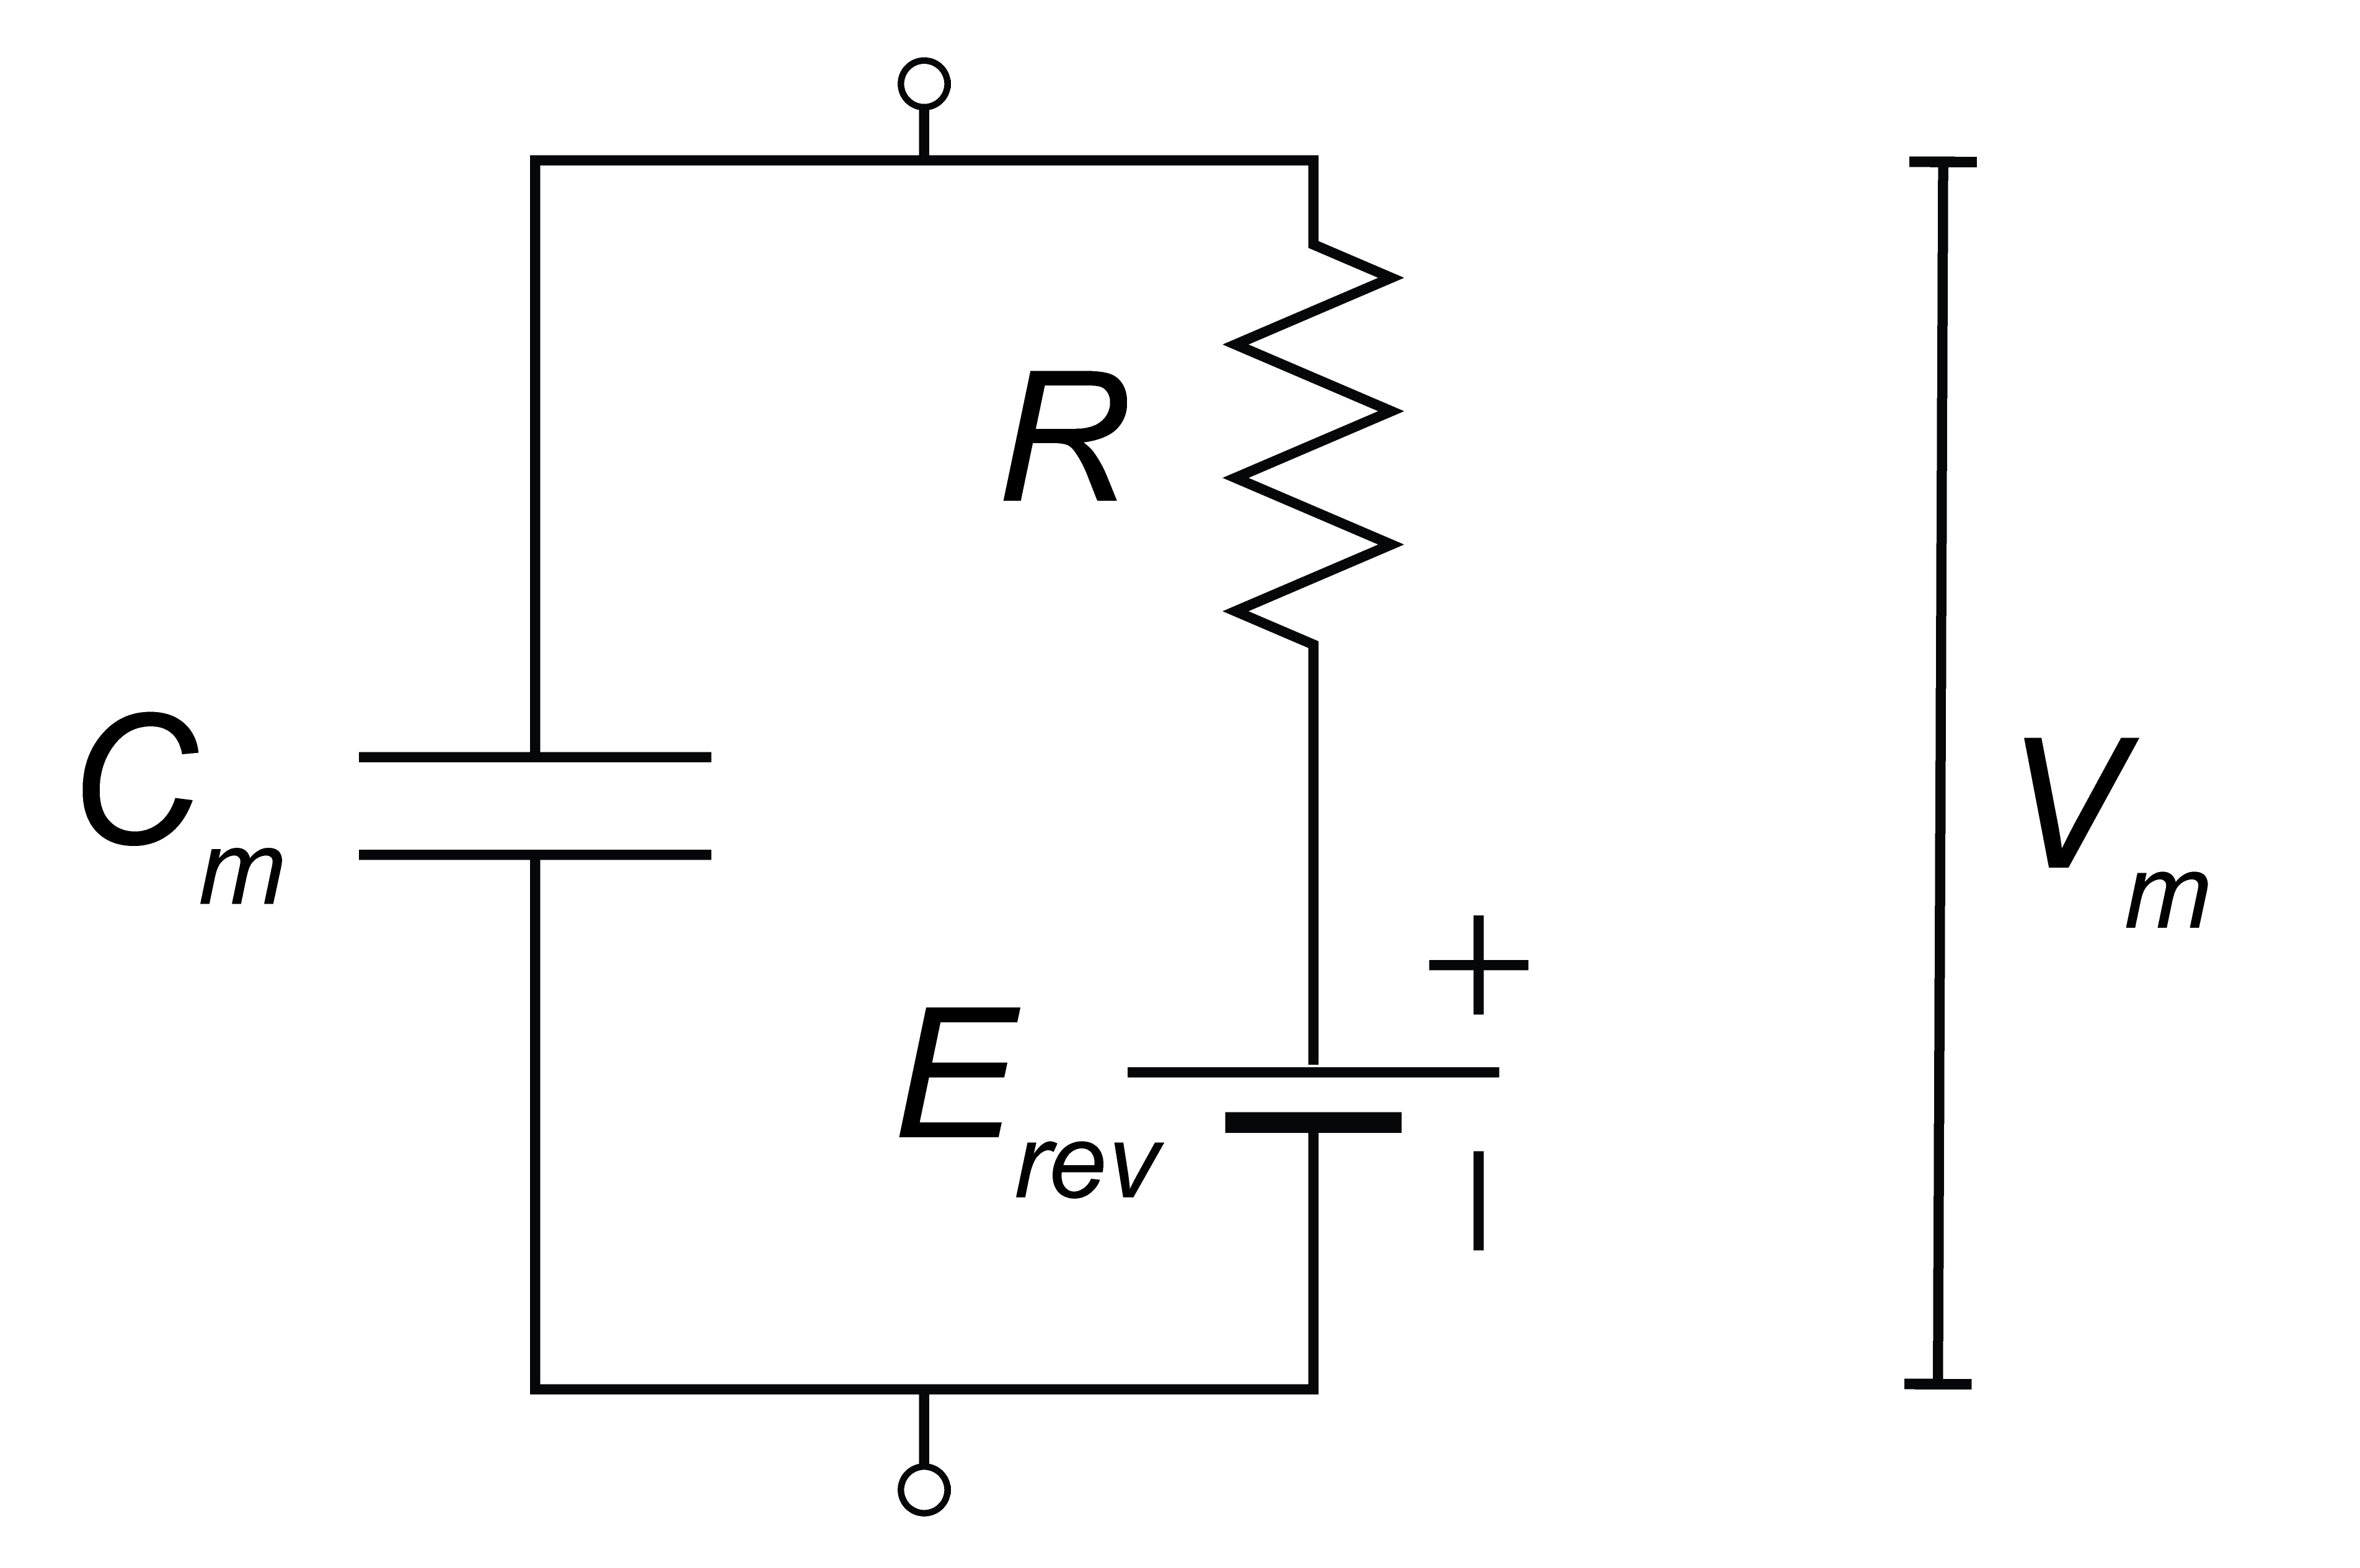

In [49]:
Image('CompModNervSys-NernstVm/resources/RC_circuit.png',width=250)

There's only one path for current to flow, so we know the capacitive current is always equal and opposite to the ionic current:

$I_{C}(t) = -I_{ion}(t)$.

Recall, the equation for current in a capacitor is $I_{C} = CdV/dt$ and the equation for current through an ion channel with a reversal potential is just the modified version of Ohm's law we introduced in class, $I_{ion} = (1/R)(V_{m} - E_{rev})$. Putting these together we have:

$C_{m}\frac{dV_{m}(t)}{dt} = -(V_{m}(t) - E_{rev})/R_{m}$.

This is just a first order ordinary differential equation, which you may have seen before. I won't go through the derivation here, but here's the solution for $V_{m}$:

$V_{m}(t) = (V_{0}-E_{rev})e^{-t/R_{m}C_{m}} + E_{rev}$,

where $V_{0}$ is $V_{m}$ at $t=0$. 

***Q4***: First, what is $V_{m}$ at equilibrium ($t \rightarrow \infty$) and why?

**Vm is Erev at t->infinity. Looking at the equation for Vm(t), the -t in the exponent causes that entire first term to approach zero as t gets very large. Conceptually, the reversal potential is defined as the point at which the net current reverses, and is thus zero. So at equilibrium, when there is no longer a current (driving force is zero), we will also be at the reversal potential.**

Now, let's use this model to simulate a simplified version of the experiment we conducted above where we wanted to increase the resting membrane potential by $10 mV$. Imagine we started with a reversal potential, in this case of our nonspecific leak conductance $E_{rev}$, of $-70 mV$, and we had a way of instantaneously changing the ion concentrations in the bath to generate our new reversal potential, $-60 mV$. 

Use the equation above and `numpy`/`matplotlib` to plot the voltage in $mV$ vs. time in $ms$. Use the $R$ and $C$ values we calculated at the beginning for a spherical cell for $R_{m}$ and $C_{m}$. Be careful about units!

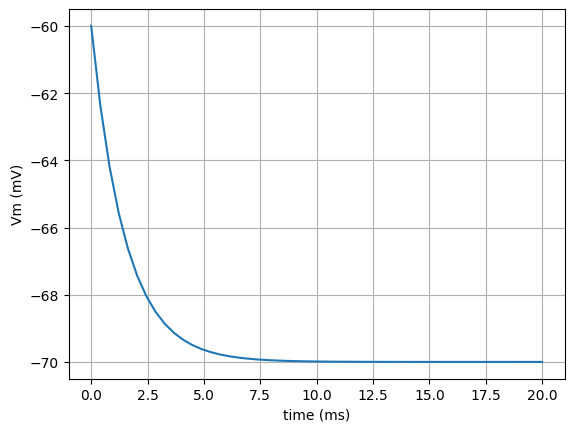

In [57]:
t = np.linspace(0,.02) # your code goes here) # time in seconds
V0 = -60
Erev = -70
rho_m = 5 * 10**9 # resistivity - Ohm*cm 
eps_m = 0.3e-6 # dielectric constant - uF/cm
d = 10e-4 # diameter - cm
th = 3e-7 # thickness - cm 
Rm = rho_m*th # Ohmcm2
Cm = eps_m / th * 1e-6 # F/cm2
e = math.e

Vm = (V0-Erev)*e**(-t/(Rm*Cm)) + Erev # membrane voltage in mV

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t*1e3,Vm)
ax.set_xlabel('time (ms)')
ax.set_ylabel('Vm (mV)')
ax.grid(visible=True)

As you may know from a differential equations course, the product $RC$ in this equation is also known as the time constant $\tau$. In our case, this is known as the *membrane time constant* and is given the special symbol $\tau_{m}$. It has units of time ($\Omega \cdot F = sec$, or $k\Omega \cdot \mu F = ms$). From inspecting the equation or your plot, you can see it's the time at which the voltage reaches 63.2% ($1-1/e$) of it's steady state value (or increases by 36.8%). In general, the time constant is a measure of how fast the membrane voltage can change in response to a stimulus (shorter times being faster). In our artificial situation, this was an instant change in bath concentrations, but later, this will be currents generated by synaptic inputs or electrical stimulation we apply. 

Below, try overlaying plots of the same manipulation if the time constant was doubled or halved. 

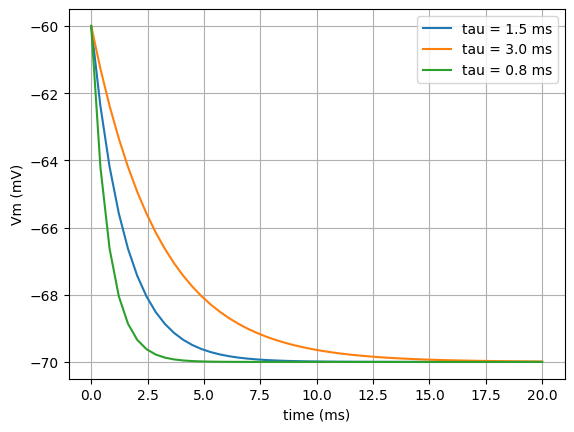

In [58]:
# Your code goes here
tau1 = Rm * Cm
tau2 = 2 * Rm * Cm
tau3 = .5 * Rm * Cm
Vm1 = (V0-Erev)*e**(-t/(tau1)) + Erev
Vm2 = (V0-Erev)*e**(-t/(tau2)) + Erev
Vm3 = (V0-Erev)*e**(-t/(tau3)) + Erev
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t*1e3,Vm1,label='tau = {:.1f} ms'.format(tau1*1e3))
ax.plot(t*1e3,Vm2,label='tau = {:.1f} ms'.format(tau2*1e3))
ax.plot(t*1e3,Vm3,label='tau = {:.1f} ms'.format(tau3*1e3))
ax.set_xlabel('time (ms)')
ax.set_ylabel('Vm (mV)')
ax.grid(visible=True)
ax.legend()

***Q5***: What physical variable could actually be changing to mediate this change in membrane time constant?

**Mathematically, it must either be a changing resistivity or dielectric constant (the thickness variable cancels out in the calculation of Rm*Cm). This is probably a result of the action of ion channels and pumps: their opening and closing as well as their addition and removal from the cell membrane by cell infrastructure. A high concentration of open K leak channels would decrease resistivity by letting charge pass through the cell membrane, this would cause the system to more quickly return to equilibrium potential, as depicted graphically above.**

Let's also take a look at the capacitive and ionic currents underlying the changes in $V_{m}$ for the first case we simulated. Plot the capacitive and ionic current as current densities in units of $pA/\mu m2$ by dividing each current by the total membrane surface area ($A = 4\pi(d/2)^2$, still using $d = 10 \; \mu m$). 

Since the capacitive current is given by $C_{m} dV_{m}/dt$, you could calculate the capacitive current numerically by taking the numerical *difference* of the voltage traces, but in this case, we can calculate the capacitive current analytically:

$I_{C}(t) = C_{m}dV_{m}/dt = C_{m}\frac{d}{dt}\left((V_{0}-E_{rev})\exp^{-t/R_{m}C_{m}} + E_{rev}\right)$

$I_{C}(t) = -\frac{V_{0} - E_{rev}}{R_{m}}\exp^{-t/R_{m}C_{m}}$

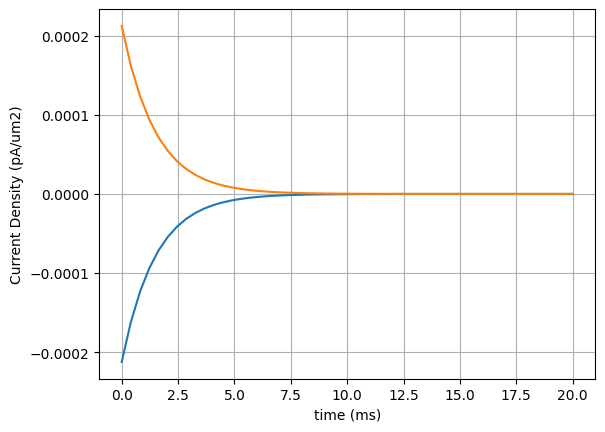

In [61]:
t = np.linspace(0,.02) # time in seconds

d = 10e-6 # diameter in m
A = 4 * math.pi * (d/2)**2 * 1e12 # SA in um2

V0 = -60e-3 # V
Erev = -70e-3 # V
rho_m = 5 * 10**9 # resistivity - Ohm*cm 
eps_m = 0.3e-6 # dielectric constant - uF/cm
th = 3e-7 # thickness - cm 
Rm = rho_m*th # Ohmcm2
Cm = eps_m / th * 1e-6# F/cm2
e = math.e

Ic = -(V0 - Erev)/(Rm*1e8) * e**(-t/(Rm*Cm)) * 1e12
Iion = -Ic
IcDensity = Ic / A
IionDensity = Iion / A

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t*1e3,IcDensity)
ax.plot(t*1e3,IionDensity)
ax.set_xlabel('time (ms)')
ax.set_ylabel('Current Density (pA/um2)')
ax.grid(visible=True)


Finally, let's test a pretty major assumption we made when deciding to represent the Nernst potential as a fixed voltage source (battery). I mentioned in lecture that the ionic fluxes required to reach equilibrium, and more generally, that occur in the normal course of neural signaling don't significantly affect the bulk concentration of ions in the cell. Suppose we accomplished the $10 mV$ change by increasing the extracellular potassium concentration. 

***Q6***: In your own words, explain the sequence of events leading from the initial condition ($V_{m} = -70 mV$) to the final steady state condition ($V_{m} = -60 mV$). 

**The relatively positive extracellular enivronment (compared to resting potential) means that positive charge would travel inward, leading to an inward current. This current would be characterized by various changes in ion pumps and channels. The K leak channels would be less conducive of K+ movement across the membrane, while Na+ channels would be more conducive for Na+ travel across the membrane into the cell. As the system approaches resting potential, the current slows down until we reach equilibrium, as depicted by the graph above.**



The excess charge from the movement of positive ions (let's use K+ for simplicity) is $Q=\Delta V_{m}C_{m}$. We can convert this from electrical charge in Coulombs to the amount of ion particles in moles $N$ using Faraday's constant, $N = Q/F$. Fill in the empty portions of the calculations below.

In [68]:
eps_m = 0.3e-6 # dielectric constant - uF/cm
th = 3e-7 # thickness - cm 
Cm = eps_m / th # uF/cm2
d = 10e-4 # cm
C = calcCsphericalCell(Cm, d) * 1e-12

deltaVm = .01 # V - change in membrane voltage
Q = deltaVm*C # C - charge built up on membrane 
F = 96485.3 # C/mol - faraday's constant
N = Q/F # number of charges moved
d = 10e-6 # m
Vol = (4/3)*np.pi*(d/2)**3 # m^3
Vol = Vol*1e3 # convert to L (1000 L per cubic meter)
Cki = 140e-3 # M - mols/liter - initial concentration
Ntot = Cki*Vol # mols K - initial
Cki2 = (Ntot - N)/Vol # M - mols/liter - final concentration

print('The intracellular concentration changed from {} mM to {} mM, {:f} %% change'.format(Cki*1e3,Cki2*1e3,100*(Cki2-Cki)/Cki))


The intracellular concentration changed from 140.0 mM to 139.9993781436136 mM, -0.000444 %% change


***Q7*** Is our assumption that ionic concentrations aren't affected by the ionic currents okay and why? Under what conditions is it a better or worse assumption, or in other words, can you think of scenarios where it would be more or less safe? 

**It's a safe assumption, as shown by the above calculations. The amount of charge that is moved across the membrane is miniscule compared to the total amount of intracellular charge. It might be a worse assumption if we start getting concerted ionic currents across the entire cell membrane (rather than a local area). If we are concerned with a local system at one specific point of the cell membrane (ex. the action of a specific ion channel), then a neighboring current may influence local ion concentrations to a significant degree.**